In [23]:
from SDLens import HookedStableDiffusionXLPipeline
from SAE import SparseAutoencoder
from utils import add_feature_on_area, replace_with_feature
import torch
import os
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
from PIL import Image

In [5]:
# Load the Pipeline

dtype = torch.float32
pipe = HookedStableDiffusionXLPipeline.from_pretrained(
    'stabilityai/sdxl-turbo',
    torch_dtype=dtype,
    device_map="balanced",
    variant=("fp16" if dtype==torch.float16 else None)
)
pipe.set_progress_bar_config(disable=True)

# Load the SAEs
 
path_to_checkpoints = './checkpoints/'

code_to_block = {
    "down.2.1": "unet.down_blocks.2.attentions.1",
    "mid.0": "unet.mid_block.attentions.0",
    "up.0.1": "unet.up_blocks.0.attentions.1",
    "up.0.0": "unet.up_blocks.0.attentions.0"
}

saes_dict = {}
means_dict = {}

for code, block in code_to_block.items():
    sae = SparseAutoencoder.load_from_disk(
        os.path.join(path_to_checkpoints, f"{block}_k10_hidden5120_auxk256_bs4096_lr0.0001", "final"),
    )
    means = torch.load(
        os.path.join(path_to_checkpoints, f"{block}_k10_hidden5120_auxk256_bs4096_lr0.0001", "final", "mean.pt"),
        weights_only=True
    )
    saes_dict[code] = sae.to('cuda', dtype=dtype)
    means_dict[code] = means.to('cuda', dtype=dtype)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/mnt/dlabscratch1/surkov/libcp/__test/SAE/sae.py:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(os.path.join(path, PATH_TO_WEIGHTS))["state_dict"]

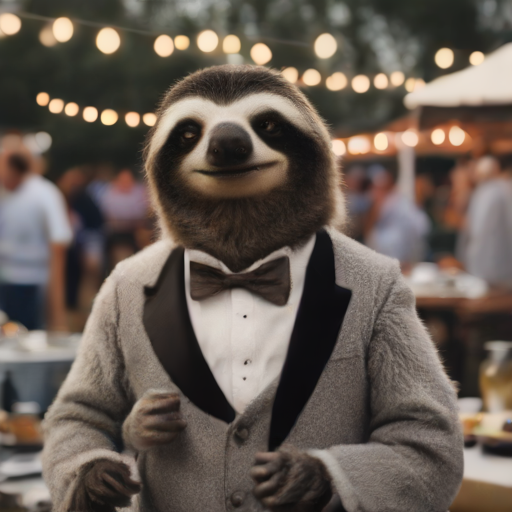

In [51]:
prompt = "A cinematic shot of a professor sloth wearing a tuxedo at a BBQ party."

output, cache = pipe.run_with_cache(
    prompt,
    positions_to_cache=list(code_to_block.values()),
    save_input=True,
    save_output=True,
    num_inference_steps=1,
    guidance_scale=0.0,
    generator=torch.Generator(device="cpu").manual_seed(42)
)

output.images[0]

In [52]:
def generate_sparse_maps(cache, code):
    block = code_to_block[code]
    sae = saes_dict[code]
    diff = cache["output"][block] - cache["input"][block]
    diff = diff.permute(0, 1, 3, 4, 2).squeeze(0).squeeze(0)
    with torch.no_grad():
        sparse_maps = sae.encode(diff)
    return sparse_maps    

In [53]:
sparse_maps = generate_sparse_maps(cache, "down.2.1")
top_features = sparse_maps.mean(axis=(0, 1)).topk(10).indices.cpu().tolist()
print("Top features:", top_features)

Top features: [1674, 4608, 4539, 2881, 4751, 567, 1226, 3119, 2345, 2128]


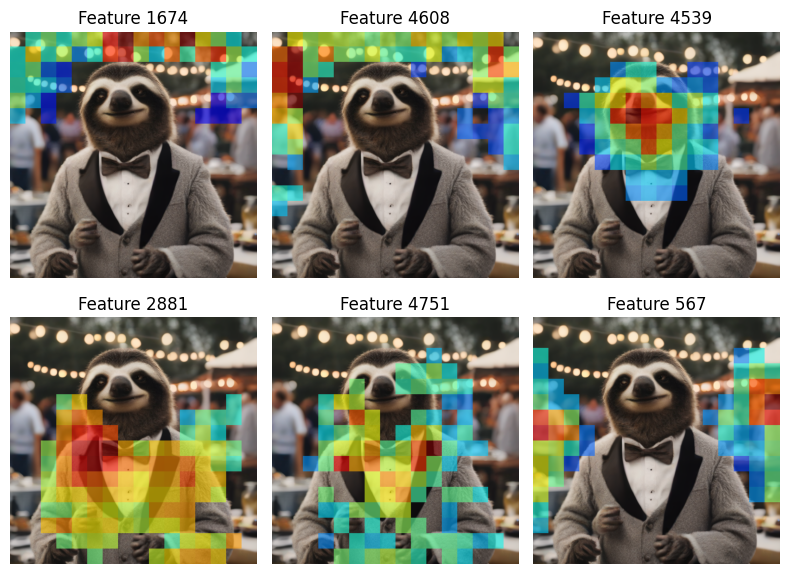

In [56]:
def plot_image_heatmap(output, sparse_maps, feature):
    heatmap = sparse_maps[:, :, feature].cpu().numpy()
    heatmap = np.kron(heatmap, np.ones((32, 32)))
    image = output.images[0]
    image = image.convert("RGBA")
    
    jet = plt.cm.jet
    cmap = jet(np.arange(jet.N))
    cmap[:1, -1] = 0
    cmap[1:, -1] = 0.6
    cmap = ListedColormap(cmap)
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    heatmap_rgba = cmap(heatmap)
    heatmap_image = Image.fromarray((heatmap_rgba * 255).astype(np.uint8))
    heatmap_with_transparency = Image.alpha_composite(image, heatmap_image)

    return heatmap_with_transparency

plt.figure(figsize=(8, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(plot_image_heatmap(output, sparse_maps, top_features[i]))
    plt.title(f"Feature {top_features[i]}")
    plt.axis("off")
plt.tight_layout()

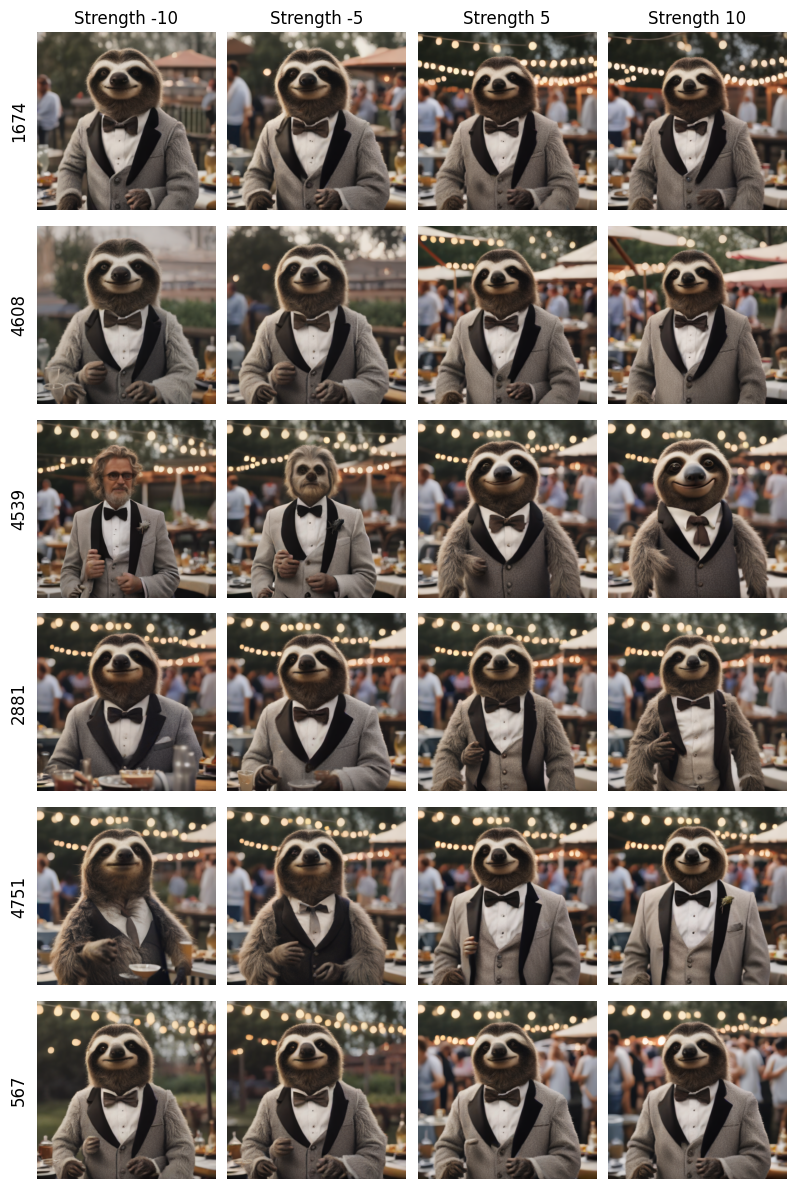

In [102]:
def activation_modulation(sparse_maps, code, feature, strength):
    block = code_to_block[code]
    output = pipe.run_with_hooks(
        prompt,
        position_hook_dict={
            block: lambda *args, **kwargs: add_feature_on_area(
                saes_dict[code],
                feature,
                sparse_maps[:, :, feature] * strength,
                *args, **kwargs
            ) 
        },
        num_inference_steps=1,
        guidance_scale=0.0,
        generator=torch.Generator(device="cpu").manual_seed(42)
    )

    return output.images[0]

plt.figure(figsize=(8, 12))
for i, feature in enumerate(top_features[:6]):
    for j, strength in enumerate([-10, -5, 5, 10]):
        plt.subplot(6, 4, i*4+j+1)
        plt.axis("off")
        plt.imshow(activation_modulation(sparse_maps, "down.2.1", feature, strength))
        if i == 0:
            plt.title(f"Strength {strength}")
        if j == 0:
            plt.text(-0.1, 0.5, f"{feature}", fontsize=12, ha='center', va='center', rotation=90, transform=plt.gca().transAxes)
plt.tight_layout()

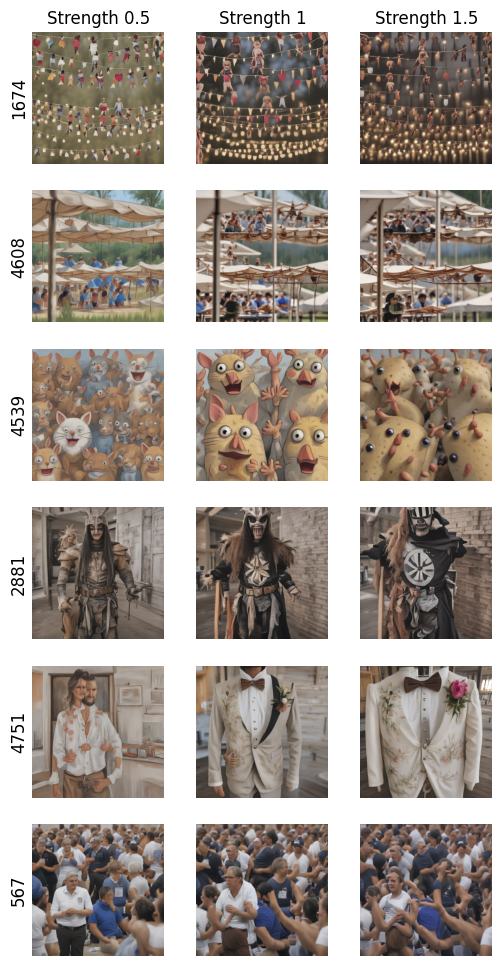

In [104]:
def empty_prompt_intervention(code, feature, strength):
    block = code_to_block[code]
    means = means_dict[code]
    output = pipe.run_with_hooks(
        "",
        position_hook_dict={
            block: lambda *args, **kwargs: replace_with_feature(
                saes_dict[code],
                feature,
                strength * means[feature] * saes_dict[code].k,
                *args, **kwargs
            ) 
        },
        num_inference_steps=1,
        guidance_scale=0.0,
        generator=torch.Generator(device="cpu").manual_seed(42)
    )

    return output.images[0]

plt.figure(figsize=(6, 12))
for i, feature in enumerate(top_features[:6]):
    for j, strength in enumerate([0.5, 1, 1.5]):
        plt.subplot(6, 3, i*3+j+1)
        plt.imshow(empty_prompt_intervention("down.2.1", feature, strength))
        plt.axis("off")
        if i == 0:
            plt.title(f"Strength {strength}")
        if j == 0:
            plt.text(-0.1, 0.5, f"{feature}", fontsize=12, ha='center', va='center', rotation=90, transform=plt.gca().transAxes)